### Introduction

I have done detailed analysis of data and presenting it to you in this notebook. I have used some models as well but main focus for this notebook is EDA.

competition: [https://www.kaggle.com/competitions/kagglex-cohort4/overview](https://www.kaggle.com/competitions/kagglex-cohort4/overview)

data: [https://www.kaggle.com/competitions/kagglex-cohort4/data](https://www.kaggle.com/competitions/kagglex-cohort4/data)

***In this competition, we have predict the price of used car. For this first i have done EDA to understand the data better and then did feature extractions and applied various models and got minimum RMSE with linear regression.***

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from category_encoders import CountEncoder, TargetEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, StackingRegressor
from sklearn.metrics import root_mean_squared_error, r2_score,  PredictionErrorDisplay, mean_absolute_error, mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, PolynomialFeatures
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.feature_selection import RFE

In [3]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

### Reading the Data

In [4]:
df = pd.read_csv('data/used_cars.csv')
df.shape

(4009, 12)

### Exploring the Data

In [5]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4009 entries, 0 to 4008
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   brand         4009 non-null   object
 1   model         4009 non-null   object
 2   model_year    4009 non-null   int64 
 3   milage        4009 non-null   object
 4   fuel_type     3839 non-null   object
 5   engine        4009 non-null   object
 6   transmission  4009 non-null   object
 7   ext_col       4009 non-null   object
 8   int_col       4009 non-null   object
 9   accident      3896 non-null   object
 10  clean_title   3413 non-null   object
 11  price         4009 non-null   object
dtypes: int64(1), object(11)
memory usage: 376.0+ KB
None


,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Ford,Utility Police Interceptor Base,2013,"51,000 mi.",E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,"$10,300"
1,Hyundai,Palisade SEL,2021,"34,742 mi.",Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,"$38,005"
2,Lexus,RX 350 RX 350,2022,"22,372 mi.",Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,NaN,"$54,598"
3,INFINITI,Q50 Hybrid Sport,2015,"88,900 mi.",Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,"$15,500"
4,Audi,Q3 45 S line Premium Plus,2021,"9,835 mi.",Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,NaN,"$34,999"


Clearly, we do not have any missing values in any of the columns. So, now we will look into univariate, bivariate and multivariate analysis. One thing to observe is target feature is continuous so it's a **regression problem**. And, among input features only **milage** feature is **continuous**, rest all are categorical features.

#### Target Feature (price)

In [6]:
df['price'] = df['price'].str.replace('$','').str.replace(',','').astype(float)

In [7]:
df['price'].describe()

count      4009.00000
mean      44553.19032
std       78710.63555
min        2000.00000
25%       17200.00000
50%       31000.00000
75%       49990.00000
max     2954083.00000
Name: price, dtype: float64

**max >>> 75thQ** and **mean > median** so data is ***heavily right skewed***, which means there must be ***outliers*** in our data. Let's plot box-plot to confirm our hypothesis.

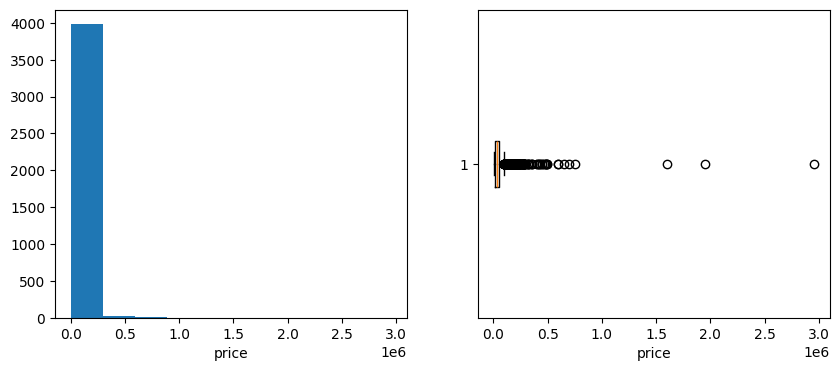

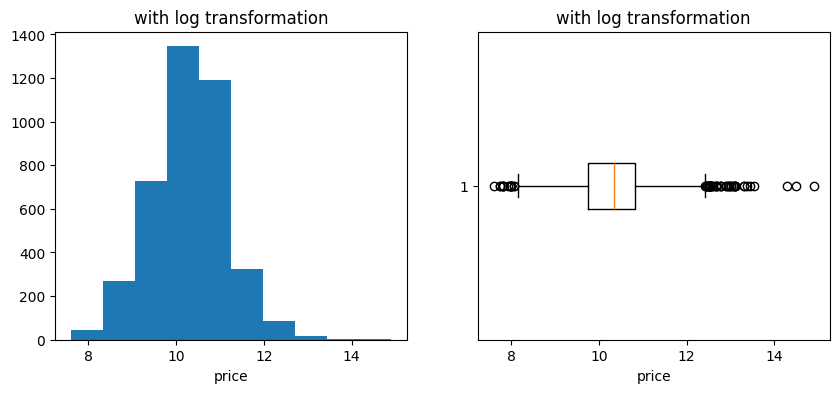

In [8]:
fig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(df['price']);
plt.xlabel('price')
plt.subplot(1,2,2)
plt.xlabel('price')
plt.boxplot(df['price'], vert=False);
fig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title('with log transformation');
plt.hist(df['price'].apply(lambda x: np.log1p(x)));
plt.xlabel('price')
plt.subplot(1,2,2)
plt.title('with log transformation');
plt.xlabel('price')
plt.boxplot(df['price'].apply(lambda x: np.log1p(x)) , vert=False);

Clearly, we have outlier so we must remove the outliers or deal with them, let's come to this later, let's continue exploring other features now.

In [9]:
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

32790.0


In [10]:
df = df[~((df['price'] < (Q1 - 1.5 * IQR)) |(df['price'] > (Q3 + 0.7 * IQR)))]
df.shape

(3520, 12)

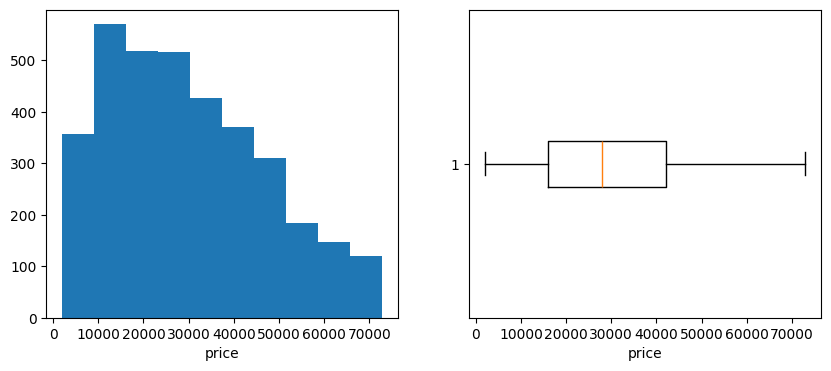

In [11]:
fig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(df['price']);
plt.xlabel('price')
plt.subplot(1,2,2)
plt.xlabel('price')
plt.boxplot(df['price'], vert=False);

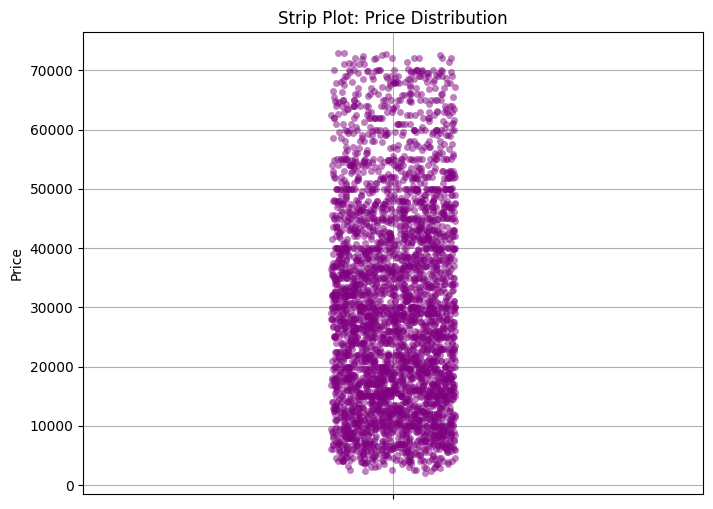

In [12]:
# Create a strip plot for the 'price' variable
plt.figure(figsize=(8, 6))
sns.stripplot(data=df, y='price', jitter=True, color='purple', alpha=0.5)
plt.title('Strip Plot: Price Distribution')
plt.ylabel('Price')
plt.grid(True)
plt.show()

### Continous Features

#### 1. milage

In [13]:
df['milage'] = df['milage'].str.replace(',', '').str.replace(' mi', '').astype(float)

In [14]:
df['milage'].describe()

count     3520.00000
mean     71527.35852
std      51916.89696
min        100.00000
25%      31000.00000
50%      61687.50000
75%     100085.00000
max     405000.00000
Name: milage, dtype: float64

milage feature also seems somewhat **right skewed** as *mean > median* but ***not heavily skewed*** as 75th percentile and max value are comparable. Let's clarify further using histogram and boxplots.

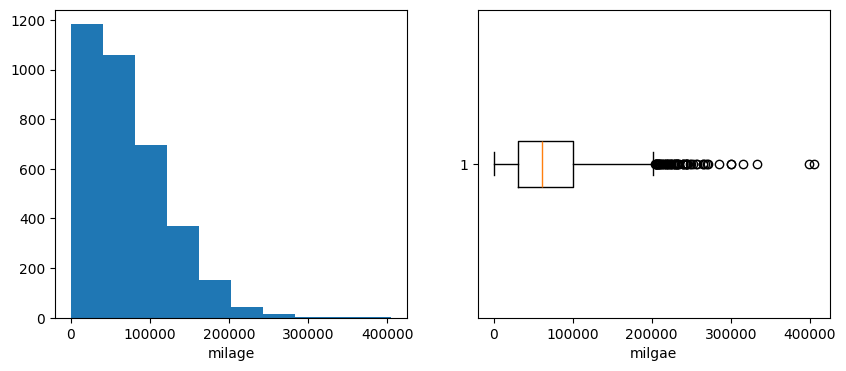

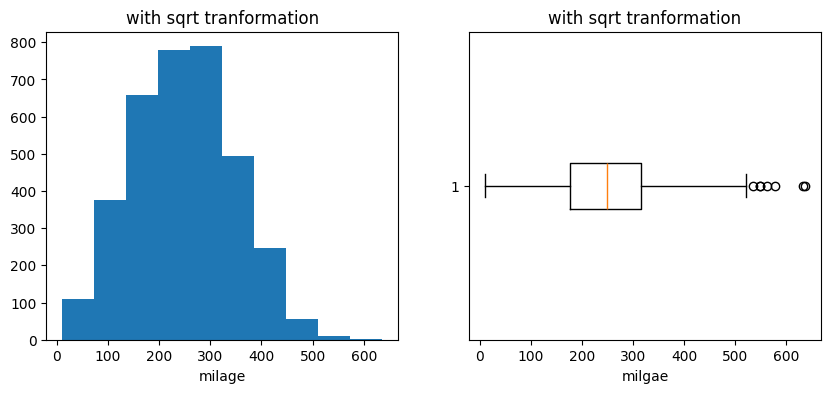

In [15]:
fig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(df['milage']);
plt.xlabel('milage')
plt.subplot(1,2,2)
plt.xlabel('milgae')
plt.boxplot(df['milage'], vert=False);
fig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title('with sqrt tranformation');
plt.hist(df['milage'].apply(lambda x: np.sqrt(x)));
plt.xlabel('milage')
plt.subplot(1,2,2)
plt.title('with sqrt tranformation');
plt.xlabel('milgae')
plt.boxplot(df['milage'].apply(lambda x: np.sqrt(x)) , vert=False);

So, here also outliers are present and we must deal with them before training the model on the data. As said earlier, we will look into removing the outliers in sometime. For now, let's continue exploring other featues as well. Before that let's first see how milage and price are related.

##### price vs milage

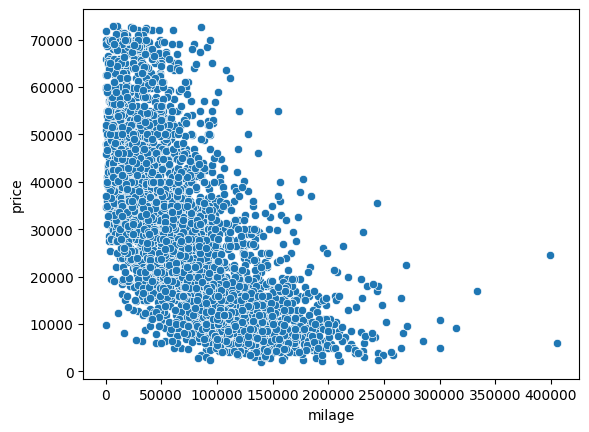

In [16]:
sns.scatterplot(df, x='milage', y='price');

What I can see from this scatter plot is that, if we do not consider the outliers price and milage do not have any fixed sort of relationship, as milage is increasing most of the cars have less price, however some of them have comparable higher prices as low milage car's price. And as milage is increasing, car's price is decreasing. however for low milage the car's price is evenly distributre in price block of < 50K dollars. So, only milage is not affecting the price atmost, many other features are also having strong say in deciding the price of car

#### 2. model_year

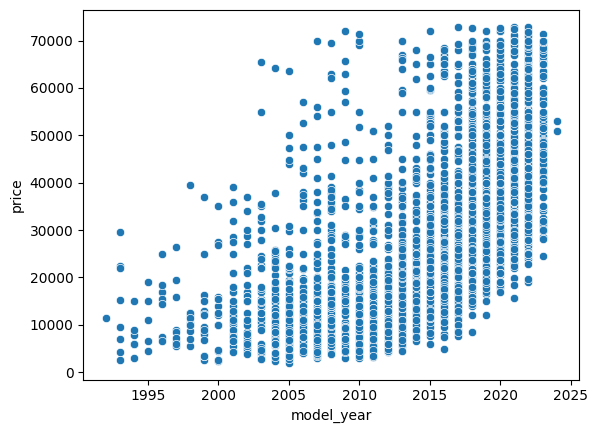

In [17]:
sns.scatterplot(df,x='model_year',y='price');

In [18]:
df['model_year'].describe()

count   3520.00000
mean    2014.93835
std        6.06130
min     1992.00000
25%     2012.00000
50%     2016.00000
75%     2020.00000
max     2024.00000
Name: model_year, dtype: float64

In [19]:
current_year = df['model_year'].max()
df['car_age'] = df['model_year'].apply(lambda x: current_year-x+1)
df.head(2)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,car_age
0,Ford,Utility Police Interceptor Base,2013,51000.00000,E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,10300.00000,12
1,Hyundai,Palisade SEL,2021,34742.00000,Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,38005.00000,4


In [20]:
df['milage_per_year'] = df[['milage','car_age']].apply(lambda x: x.iloc[0]/x.iloc[1], axis=1)
df.head(2)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,car_age,milage_per_year
0,Ford,Utility Police Interceptor Base,2013,51000.00000,E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,10300.00000,12,4250.00000
1,Hyundai,Palisade SEL,2021,34742.00000,Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,38005.00000,4,8685.50000


### Categorical Features

#### 1. brand

In [21]:
df['brand'].describe()

count     3520
unique      51
top       Ford
freq       362
Name: brand, dtype: object

There are only 53 unique brands, so we can visualize it using plots. Let's look at it now.

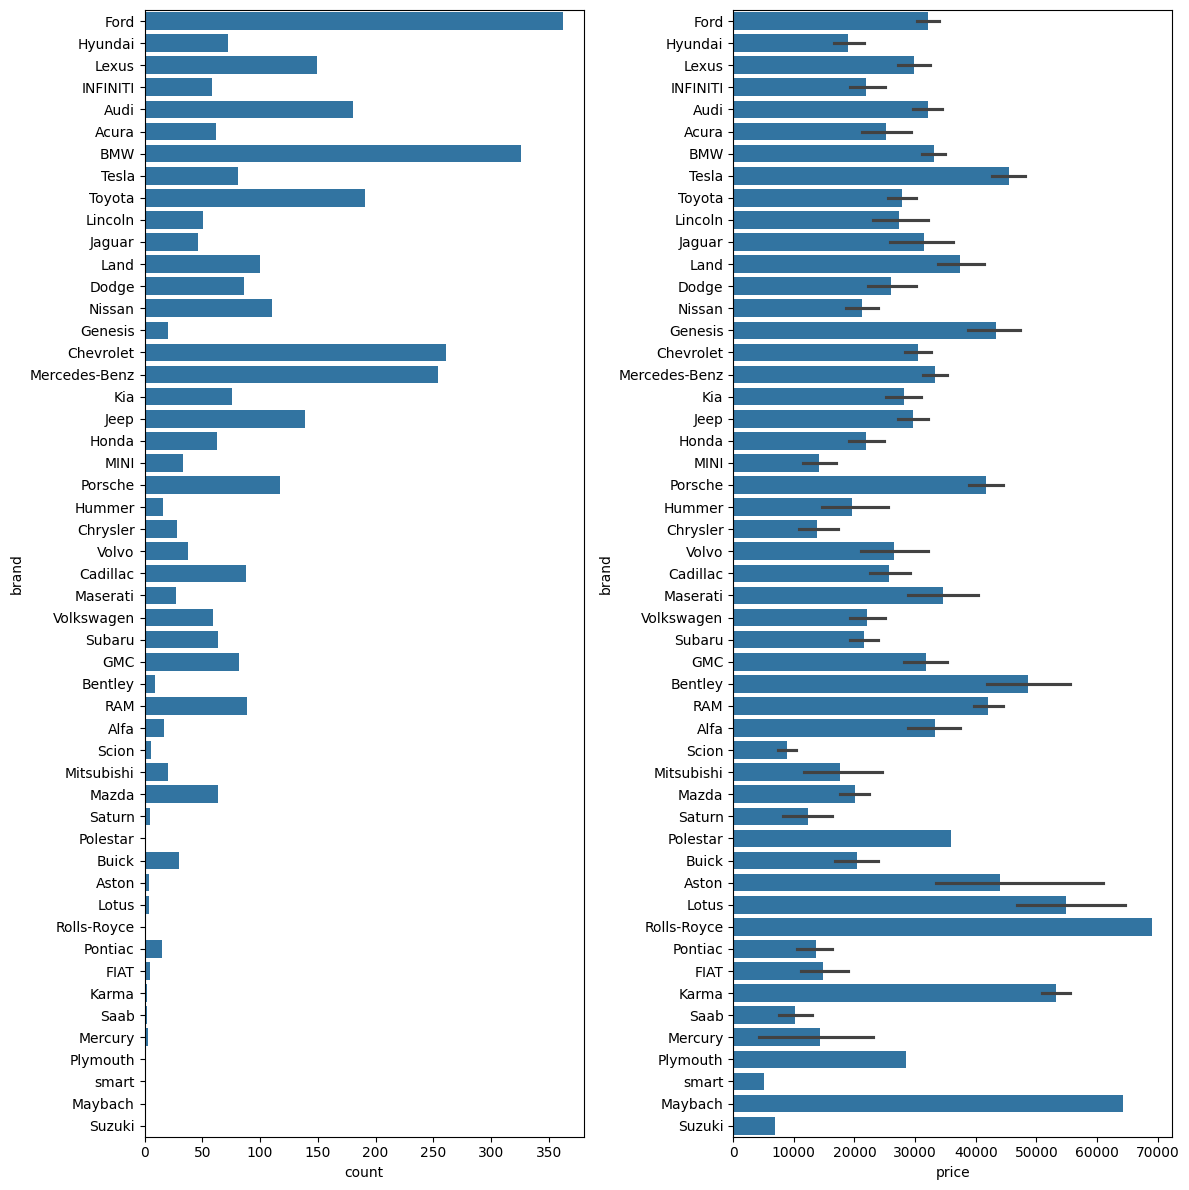

In [22]:
fig = plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
sns.countplot(df,y='brand',orient="y")
plt.subplot(1,2,2)
sns.barplot(df,y='brand',x='price');
fig.tight_layout()
plt.show()

In [23]:
print(df['brand'].value_counts(sort=True).to_dict())

{'Ford': 362, 'BMW': 326, 'Chevrolet': 261, 'Mercedes-Benz': 254, 'Toyota': 191, 'Audi': 180, 'Lexus': 149, 'Jeep': 139, 'Porsche': 117, 'Nissan': 110, 'Land': 100, 'RAM': 89, 'Cadillac': 88, 'Dodge': 86, 'GMC': 82, 'Tesla': 81, 'Kia': 76, 'Hyundai': 72, 'Mazda': 64, 'Subaru': 64, 'Honda': 63, 'Acura': 62, 'Volkswagen': 59, 'INFINITI': 58, 'Lincoln': 51, 'Jaguar': 46, 'Volvo': 38, 'MINI': 33, 'Buick': 30, 'Chrysler': 28, 'Maserati': 27, 'Mitsubishi': 20, 'Genesis': 20, 'Alfa': 17, 'Hummer': 16, 'Pontiac': 15, 'Bentley': 9, 'Scion': 6, 'Saturn': 5, 'FIAT': 5, 'Aston': 4, 'Lotus': 4, 'Mercury': 3, 'Karma': 2, 'Saab': 2, 'Polestar': 1, 'Rolls-Royce': 1, 'Plymouth': 1, 'smart': 1, 'Maybach': 1, 'Suzuki': 1}


In [24]:
df['brand_value'] = TargetEncoder(cols=['brand'], min_samples_leaf=20, smoothing=10).fit_transform(df.drop('price',axis=1), df['price'])['brand']

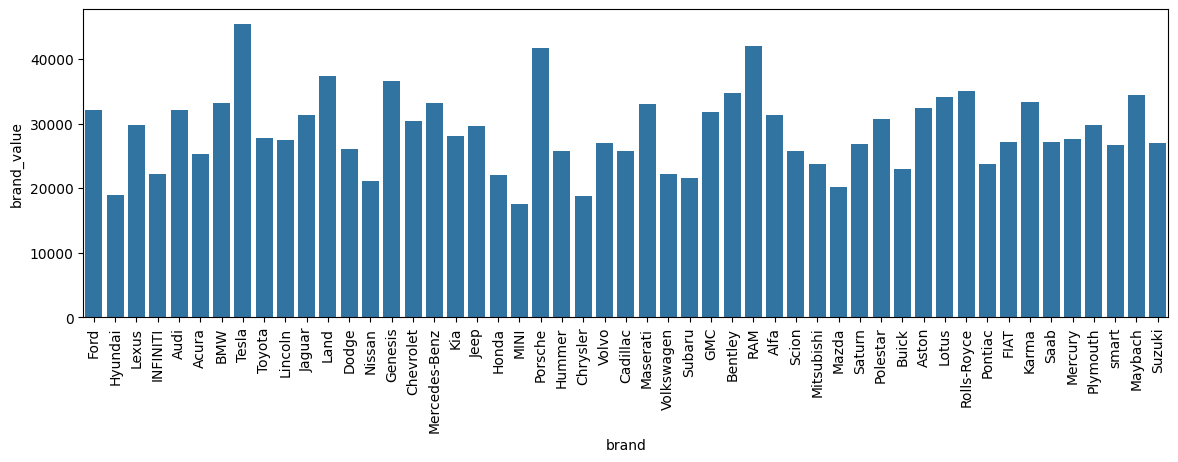

In [25]:
plt.figure(figsize=(14,4))
sns.barplot(df,x='brand',y='brand_value');
fig.tight_layout()
plt.xticks(rotation=90)
plt.show()

<Axes: xlabel='price', ylabel='brand'>

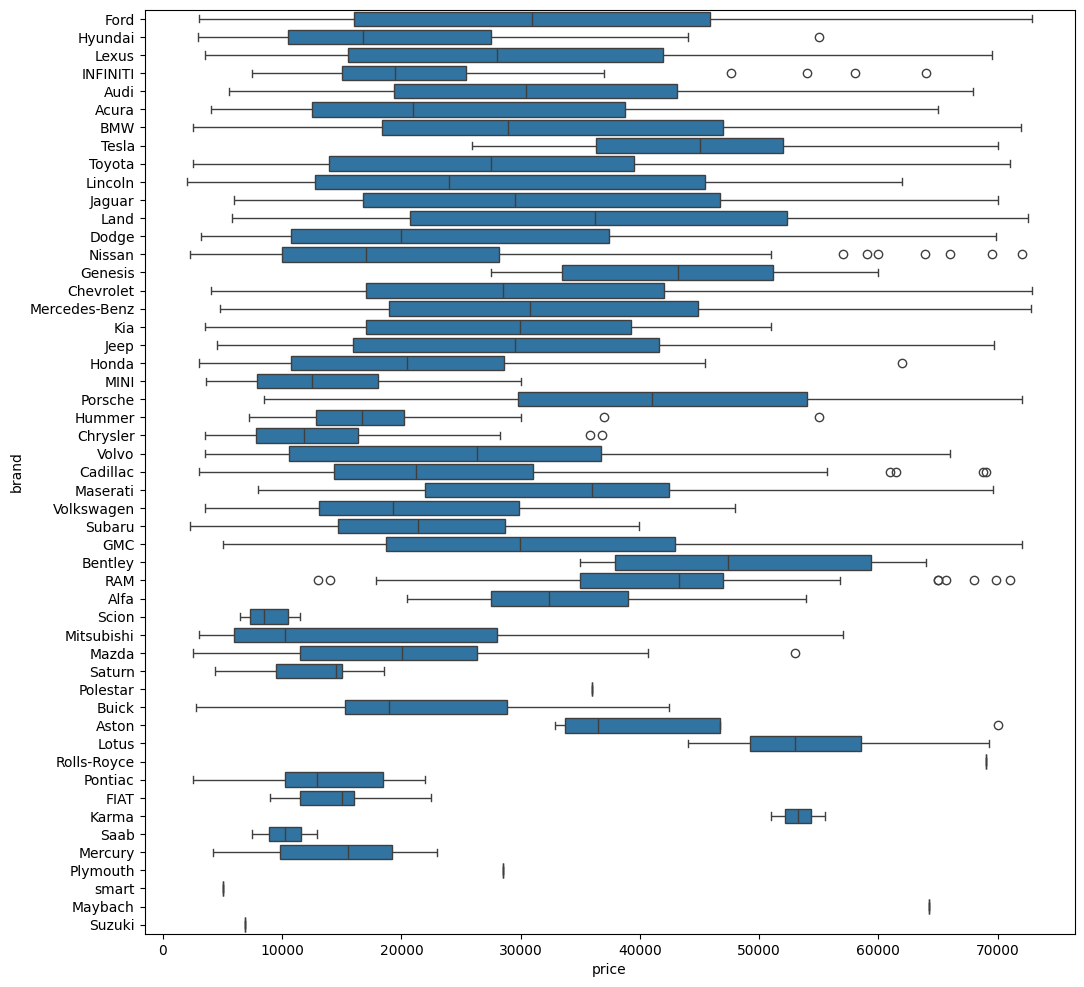

In [26]:
plt.figure(figsize=(12,12))
sns.boxplot(df,y='brand',x='price')

Boxplot shows for each brand also, there are outliers in price, which means solely price depends on model a lot but there are other factors aswell to price a car of particular brand.

#### 2. model

In [27]:
df['model'].describe()

count        3520
unique       1704
top       M3 Base
freq           29
Name: model, dtype: object

In [28]:
df['model_value'] = TargetEncoder(cols=['model'], min_samples_leaf=20, smoothing=10).fit_transform(df.drop('price',axis=1), df['price'])['model']
df['brand_model_value'] = df[['brand_value', 'model_value']].apply(lambda x: x.iloc[0]*x.iloc[1], axis=1) 
df.head(2)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,car_age,milage_per_year,brand_value,model_value,brand_model_value
0,Ford,Utility Police Interceptor Base,2013,51000.00000,E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,10300.00000,12,4250.00000,32068.18785,26993.78806,865641866.02809
1,Hyundai,Palisade SEL,2021,34742.00000,Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,38005.00000,4,8685.50000,19007.42014,30479.81165,579342585.78415


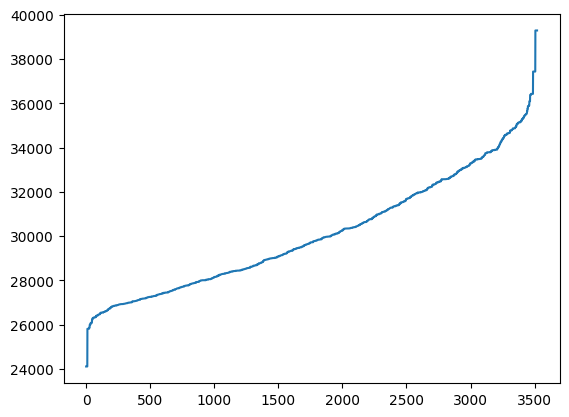

In [29]:
plt.plot(np.sort(df['model_value']));

#### 3. fuel_type

In [30]:
df['fuel_type'].describe()

count         3388
unique           7
top       Gasoline
freq          2928
Name: fuel_type, dtype: object

In [31]:
df['fuel_type'].value_counts(sort=True)

fuel_type
Gasoline          2928
Hybrid             153
E85 Flex Fuel      138
Diesel              99
–                   40
Plug-In Hybrid      28
not supported        2
Name: count, dtype: int64

In [80]:
df['fuel_type'] = df['fuel_type'].fillna('Gasoline')

Let's first see what are these not supported fuel type cars.

In [81]:
df.iloc[np.where(df['fuel_type']=='not supported')]

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,...,price,car_age,milage_per_year,brand_value,model_value,brand_model_value,horse_power,engine_volume,engine_volume_power,automatic
2894,Toyota,Mirai Limited,2021,44000.00000,not supported,182.0HP Electric Motor Hydrogen Fuel,A/T,Gray,Black,1,...,18500.00000,4,11000.00000,27827.27233,28488.59345,792759848.27200,182.00000,3.58584,652.62221,1
3700,Toyota,Mirai Base,2016,40000.00000,not supported,151.0HP Electric Motor Hydrogen Fuel,A/T,Silver,Black,1,...,9500.00000,9,4444.44444,27827.27233,27317.61718,760174772.73274,151.00000,3.58584,541.46129,1


In [82]:
list(df.iloc[np.where(df['fuel_type'] == 'Diesel')]['engine'].head(5))

['3.0L V6 Cylinder Engine Diesel Fuel',
 '370.0HP 6.7L Straight 6 Cylinder Engine Diesel Fuel',
 '188.0HP 3.0L V6 Cylinder Engine Diesel Fuel',
 '210.0HP 2.0L 4 Cylinder Engine Diesel Fuel',
 '188.0HP 3.0L V6 Cylinder Engine Diesel Fuel']

In [83]:
list(df.iloc[np.where(df['fuel_type'] == 'Hybrid')]['engine'].head(5))

['354.0HP 3.5L V6 Cylinder Engine Gas/Electric Hybrid',
 '120 AH',
 '382.0HP 3.0L Straight 6 Cylinder Engine Gasoline/Mild Electric Hybrid',
 '199.0HP 2.4L 4 Cylinder Engine Gas/Electric Hybrid',
 '1.6L I4 16V GDI DOHC Hybrid']

In [84]:
list(df.iloc[np.where(df['fuel_type'] == 'E85 Flex Fuel')]['engine'].head(5))

['300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capability',
 '120.0HP 2.2L 4 Cylinder Engine Flex Fuel Capability',
 '2.0L I4 16V GDI DOHC Turbo Flexible Fuel',
 '300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capability',
 '5.3L V8 16V MPFI OHV Flexible Fuel']

In [85]:
list(df.iloc[np.where(df['fuel_type'] == 'Plug-In Hybrid')]['engine'].head(5))

['400.0HP 2.0L 4 Cylinder Engine Plug-In Electric/Gas',
 '416.0HP 3.0L V6 Cylinder Engine Plug-In Electric/Gas',
 '266.0HP 2.5L 4 Cylinder Engine Plug-In Electric/Gas',
 '188.0HP 2.0L 4 Cylinder Engine Plug-In Electric/Gas',
 '400.0HP 2.0L 4 Cylinder Engine Plug-In Electric/Gas']

In [86]:
list(df.iloc[np.where(df['fuel_type'] == 'Gasoline')]['engine'].head(5))

['3.8L V6 24V GDI DOHC',
 '3.5 Liter DOHC',
 '2.0L I4 16V GDI DOHC Turbo',
 '2.4 Liter',
 '292.0HP 2.0L 4 Cylinder Engine Gasoline Fuel']

So, after looking all above datapoints my hypothesis is a fuel_type feature is derived from engine. Let's check it by finding how many records satisfy it.

In [87]:
def contain(row):
  fuel = row.iloc[0]
  fuel = '' if not fuel else fuel
  engine = row.iloc[1]
  if fuel in engine:
    return True
  return False

num = sum(df[['fuel_type','engine']].apply(contain,axis=1))
den = len(df) - len(np.where(df['fuel_type'] == 'not supported')[0]) - len(np.where(df['fuel_type'] == '–')[0])
num/den*100

76.79700977573319

So, **76%** of our records have **fuel type derived from engine** not considering records where fuel type is 'not supported' or not give

In [88]:
# Values of engine where fuel_type in missing
df.iloc[np.where(df['fuel_type'] == '–')]['engine'].value_counts()

engine
–    40
Name: count, dtype: int64

In [89]:
# Values of fuel_type where engine is missing
df.iloc[np.where(df['engine'] == '–')]['fuel_type'].value_counts()

fuel_type
–    40
Name: count, dtype: int64

So, what I can infer from fuel_type feature, is more or less derived from engine value however 291 records are there where we neither have data of engine nor the fuel_type. 44 records have fuel_type but engine information is missing. Also, 'not supported' fuel type actually are electic cars so there is not issue with it. So, we can impute missing values of fuel_type from engine if engine information is availabe. Also it shows, other features can be derived from engine like horsepower, engine volume, cylider pistern or straight pistern etc

In [90]:
df['fuel_type'] = df['fuel_type'].apply(lambda x: 'Electric' if x == '–' or x == 'not supported' else x)

##### price vs fuel_type

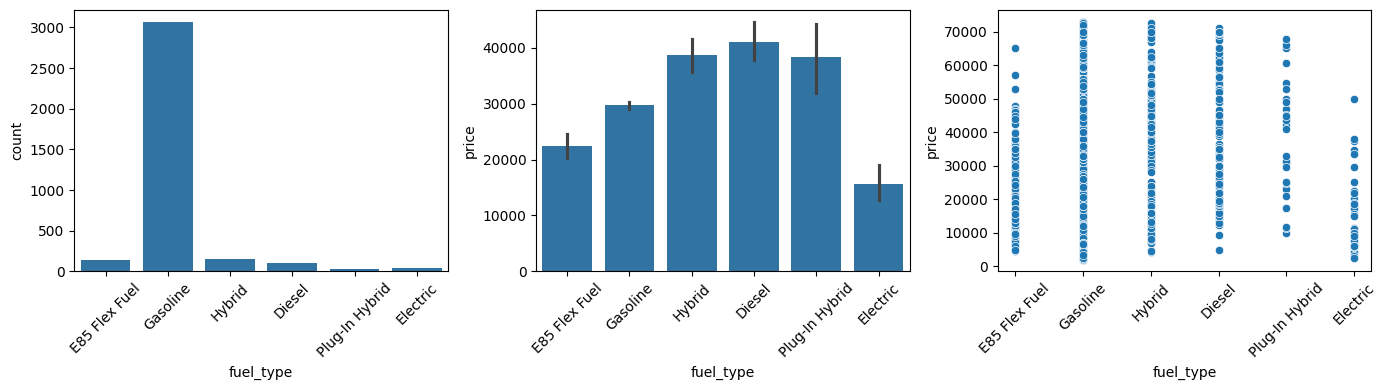

In [91]:
fig = plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
sns.countplot(df,x='fuel_type')
plt.xticks(rotation=45)
plt.subplot(1,3,2)
sns.barplot(df,x='fuel_type',y='price');
plt.xticks(rotation=45)
plt.subplot(1,3,3)
sns.scatterplot(df,x=df['fuel_type'],y=df['price'])
plt.xticks(rotation=45)
fig.tight_layout()
plt.show()

So, there is nothing like interesing here, it just shows all different fuel_type cars have prices depend on it as well as other features with Gasoline being most commonly found fuel_type in cars and it's cheap.

#### 4. engine

In [39]:
df['engine'].describe()

count                           3520
unique                          1007
top       2.0L I4 16V GDI DOHC Turbo
freq                              47
Name: engine, dtype: object

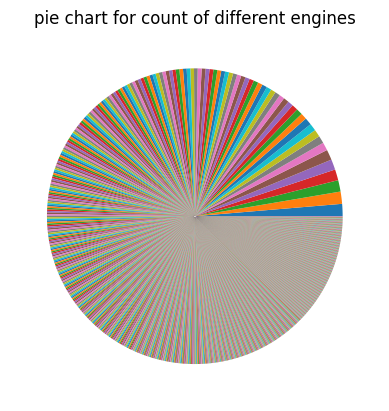

In [40]:
plt.pie(df['engine'].value_counts().values);
plt.title('pie chart for count of different engines');

It seems engine have more than 1000 unique values because it contains much more information. So, let's first **extract features** from this column.

In [41]:
sum(df['engine'].str.contains('L'))/len(df)*100

95.14204545454545

95% of our data have engine volume defined in the engine

In [42]:
sum(df['engine'].str.contains('HP'))/len(df)*100

81.44886363636363

81% of our data have horse power defined in the engine

Extracting volume of engine cylinder and horse power

In [43]:
# Define a function to extract engine attributes
def extract_engine_attributes(engine_str):
    horsepower = re.search(r'(\d+\.\d+)HP|\d+\.\d+', engine_str)
    volume = re.search(r'(\d+\.\d+L|\d+\.\d+ Liter)', engine_str)
    return horsepower.group(1) if horsepower else '',\
           volume.group(1) if volume else ''

# Apply the function to create new columns
df[['horse_power', 'engine_volume']] = df['engine'].apply(extract_engine_attributes).apply(pd.Series)

In [44]:
df.head(2)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,car_age,milage_per_year,brand_value,model_value,brand_model_value,horse_power,engine_volume
0,Ford,Utility Police Interceptor Base,2013,51000.00000,E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,10300.00000,12,4250.00000,32068.18785,26993.78806,865641866.02809,300.0,3.7L
1,Hyundai,Palisade SEL,2021,34742.00000,Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,38005.00000,4,8685.50000,19007.42014,30479.81165,579342585.78415,None,3.8L


Since horse power feature is right skewed we will use median to impute the missing values

In [45]:
df['horse_power'].describe()

count      2948
unique      307
top       300.0
freq        107
Name: horse_power, dtype: object

In [46]:
df['horse_power'] = df['horse_power'].apply(lambda x: None if not x else float(x) )

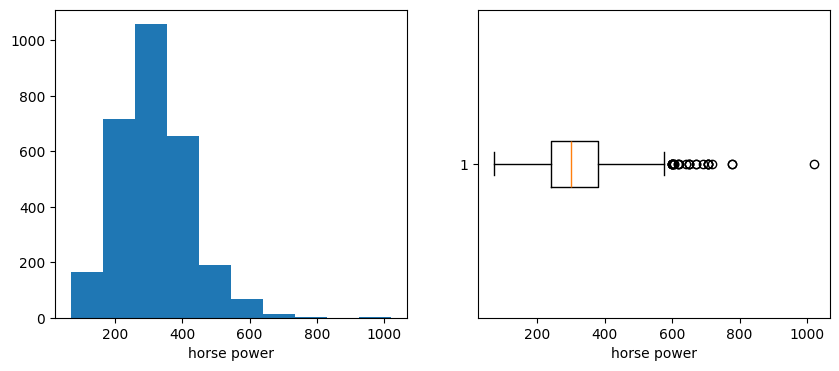

In [47]:
fig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(df['horse_power']);
plt.xlabel('horse power')
plt.subplot(1,2,2)
plt.boxplot(df[~df['horse_power'].isnull()]['horse_power'], vert=False)
plt.xlabel('horse power');

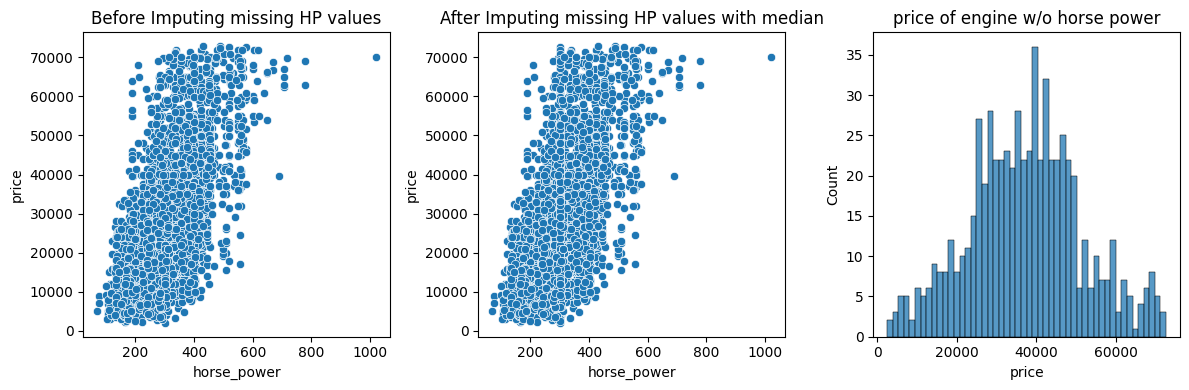

In [48]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
sns.scatterplot(df, x='horse_power', y='price')
plt.title('Before Imputing missing HP values')
plt.subplot(1,3,2)
sns.scatterplot(df[['horse_power', 'price']].fillna(df['horse_power'].quantile(0.5)), x='horse_power', y='price')
plt.title('After Imputing missing HP values with median')
plt.subplot(1,3,3)
sns.histplot(df.iloc[np.where(~df['engine'].str.contains('HP'))], x='price', bins= 50);
plt.title("price of engine w/o horse power")
fig.tight_layout()
plt.show()

In [49]:
df['horse_power'].isna().sum()

655

In [50]:
df['horse_power'] = df['horse_power'].fillna(df['horse_power'].quantile(0.5))
df['horse_power'].isna().sum()

0

In [51]:
df['engine_volume'] = df['engine_volume'].str.replace('Liter', '').str.replace('L','')

In [52]:
df['engine_volume'] = df['engine_volume'].apply(lambda x: None if len(x) == 0 else float(x))

In [53]:
df['engine_volume'].describe()

count   3336.00000
mean       3.58584
std        1.39832
min        0.65000
25%        2.50000
50%        3.50000
75%        4.60000
max        8.30000
Name: engine_volume, dtype: float64

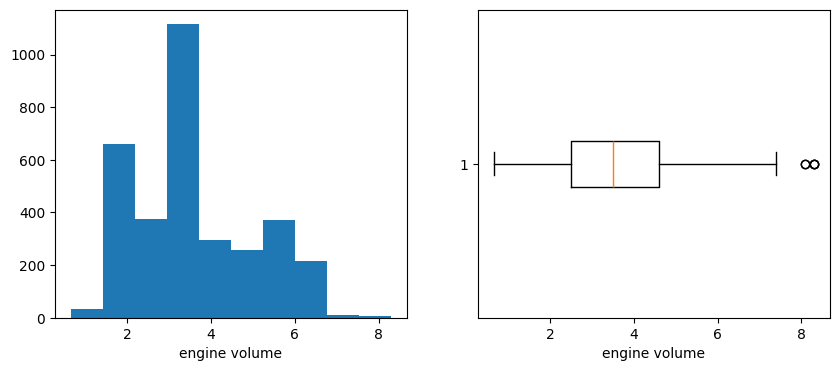

In [54]:
fig = plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(df['engine_volume']);
plt.xlabel('engine volume')
plt.subplot(1,2,2)
plt.boxplot(df[~df['engine_volume'].isnull()]['engine_volume'], vert=False)
plt.xlabel('engine volume');

volume is not skewed so we can use its mean to impute the missing values

In [55]:
df['engine_volume'].isna().sum()

184

In [56]:
df['engine_volume'] = df['engine_volume'].fillna(df['engine_volume'].mean())
df['engine_volume'].isna().sum()

0

##### interaction feature (engine_volume*horse_power)

In [57]:
df['engine_volume_power'] = df[['engine_volume', 'horse_power']].apply(lambda x: x.iloc[0]*x.iloc[1], axis=1)
df.head(2)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price,car_age,milage_per_year,brand_value,model_value,brand_model_value,horse_power,engine_volume,engine_volume_power
0,Ford,Utility Police Interceptor Base,2013,51000.00000,E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,10300.00000,12,4250.00000,32068.18785,26993.78806,865641866.02809,300.00000,3.70000,1110.00000
1,Hyundai,Palisade SEL,2021,34742.00000,Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,38005.00000,4,8685.50000,19007.42014,30479.81165,579342585.78415,301.00000,3.80000,1143.80000


#### 5. transmission

In [58]:
df['transmission'].describe()

count     3520
unique      47
top        A/T
freq       960
Name: transmission, dtype: object

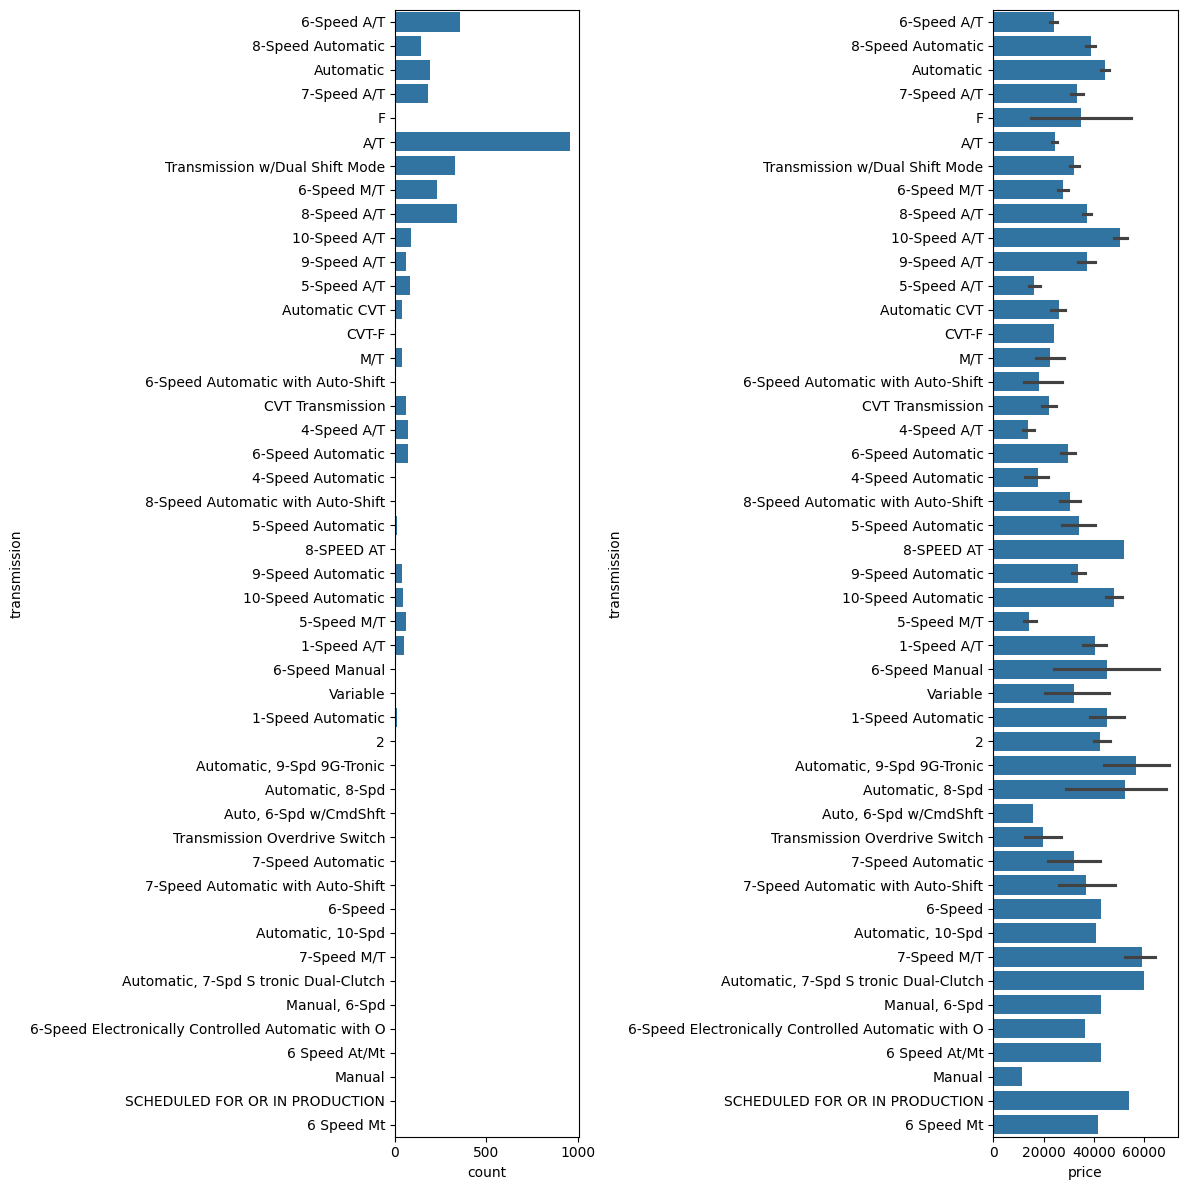

In [59]:
fig = plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
sns.countplot(df,y='transmission',orient="y")
plt.subplot(1,2,2)
sns.barplot(df,y='transmission',x='price');
fig.tight_layout()
plt.show()

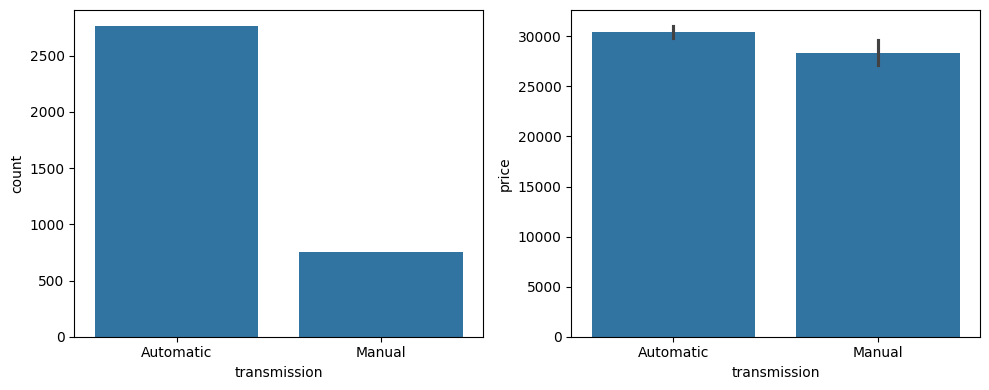

In [60]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.countplot(x=df['transmission'].apply(lambda x: 'Automatic' if 'Automatic' in x or ('A/T' in x and 'M/T' not in x) else 'Manual'));
plt.subplot(1,2,2)
sns.barplot(y=df['price'],x=df['transmission'].apply(lambda x: 'Automatic' if 'Automatic' in x or ('A/T' in x and 'M/T' not in x) else 'Manual'))
plt.tight_layout()
plt.show()

Although, count of automatic is more than manual but in terms of price both are almost equal. thus, will use one hot encoding for transmission

In [61]:
df['automatic'] = df['transmission'].apply(lambda x: 1 if 'Automatic' in x or 'A/T' in x else 0)

#### 6. External color

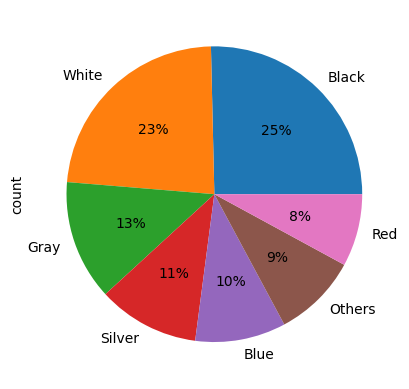

In [62]:
basic_colors = df['ext_col'].value_counts().head(6).index.tolist()
def handle_ext_color(s):
  s = s.split(' ')
  for col in basic_colors:
    if col in s:
      return col
  return 'Others'
df['ext_col'].apply(handle_ext_color).value_counts().plot(kind='pie',autopct='%1.0f%%');

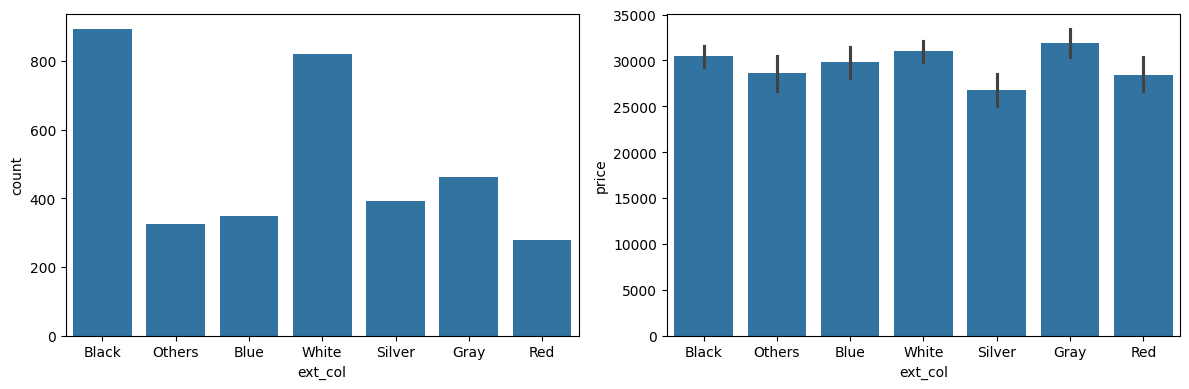

In [63]:
fig = plt.figure(figsize=(12,4))
df_extcolor = df.copy()
df_extcolor['ext_col'] = df['ext_col'].apply(handle_ext_color)
plt.subplot(1,2,1)
sns.countplot(df_extcolor,x='ext_col')
plt.subplot(1,2,2)
sns.barplot(df_extcolor,x='ext_col',y='price');
fig.tight_layout()
plt.show()

So, since cars with color as others definetely have high prices because they kind of seems customized cars.

#### 7. Internal color

In [64]:
df['int_col'].describe()

count      3520
unique      120
top       Black
freq       1781
Name: int_col, dtype: object

In [65]:
df['int_col'].value_counts().head(10)

int_col
Black        1781
Beige         509
Gray          447
Brown         133
–             113
White         101
Red            95
Jet Black      53
Ebony          39
Blue           23
Name: count, dtype: int64

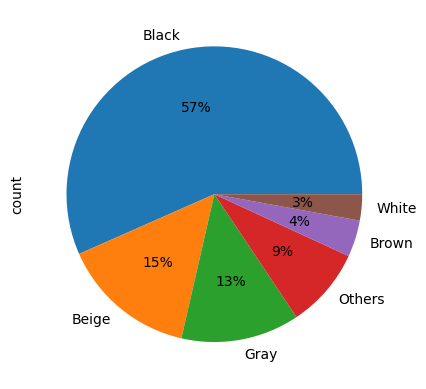

In [66]:
basic_colors = df['int_col'].value_counts().head(6).index.tolist()
mode_color = df['int_col'].mode()[0]
def handle_int_color(s):
  if s == '–':
    return mode_color
  s = s.split(' ')
  for col in basic_colors:
    if col in s:
      return col
  return 'Others'
df['int_col'].apply(handle_int_color).value_counts().plot(kind='pie',autopct='%1.0f%%');

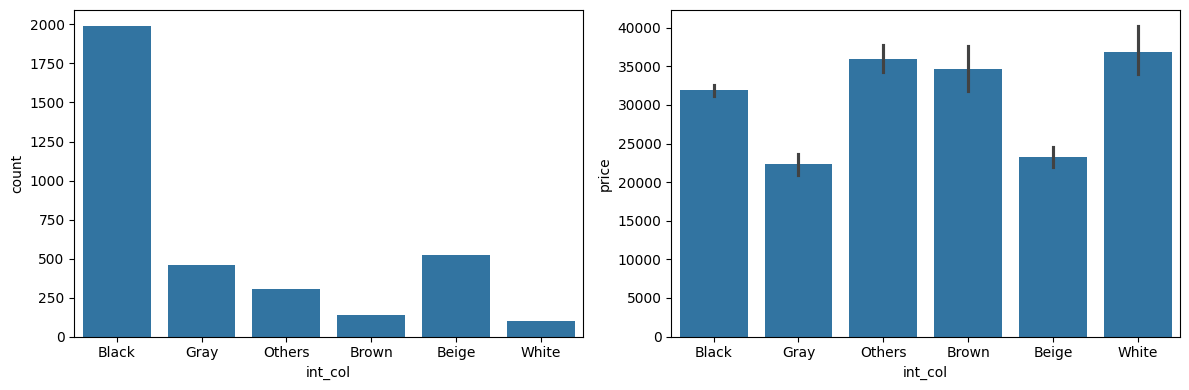

In [67]:
fig = plt.figure(figsize=(12,4))
df_intcolor = df.copy()
df_intcolor['int_col'] = df['int_col'].apply(handle_int_color)
plt.subplot(1,2,1)
sns.countplot(df_intcolor,x='int_col')
plt.subplot(1,2,2)
sns.barplot(df_intcolor,x='int_col',y='price');
fig.tight_layout()
plt.show()

Clearly white, red, others color cars are have high price and black have low price as it's available in high qunatity like most common.

In [68]:
np.unique(df['ext_col']+'_'+df['int_col']).size

462

#### 8. Accident

In [69]:
df['accident'].describe()

count              3429
unique                2
top       None reported
freq               2478
Name: accident, dtype: object

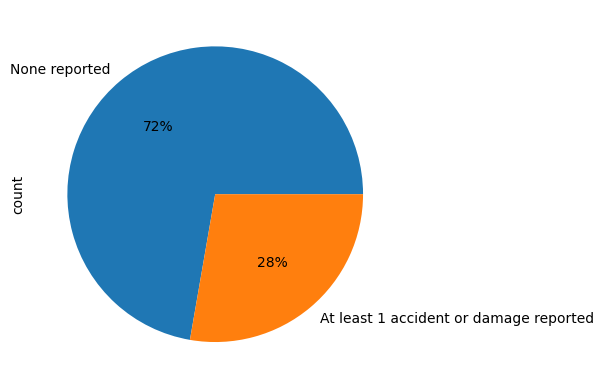

In [70]:
df['accident'].value_counts().plot(kind='pie',autopct='%1.0f%%');

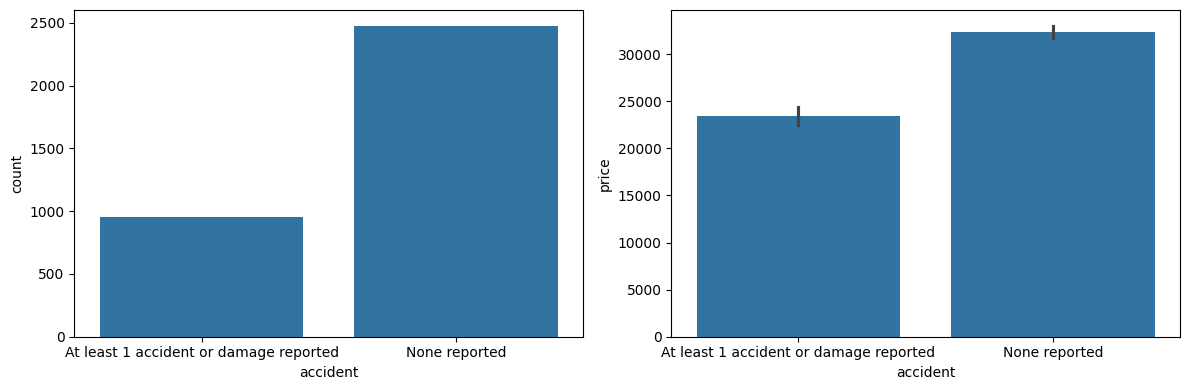

In [71]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.countplot(df,x='accident')
plt.subplot(1,2,2)
sns.barplot(df,x='accident',y='price');
fig.tight_layout()
plt.show()

In [72]:
df['accident'] = df['accident'].apply(lambda x: 1 if x == 'None reported' else 0)

Clearly, having an accident reported on that car decrease it's value and givenegative impression on buyers, so price is less

#### 9. clean title

In [73]:
df['clean_title'].describe()

count     3047
unique       1
top        Yes
freq      3047
Name: clean_title, dtype: object

In [74]:
df['clean_title'].value_counts()

clean_title
Yes    3047
Name: count, dtype: int64

All the values are 'yes' in this column, so it's of no use to use. So, we will drop this column.

In [75]:
df.head(2)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,...,price,car_age,milage_per_year,brand_value,model_value,brand_model_value,horse_power,engine_volume,engine_volume_power,automatic
0,Ford,Utility Police Interceptor Base,2013,51000.00000,E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,0,...,10300.00000,12,4250.00000,32068.18785,26993.78806,865641866.02809,300.00000,3.70000,1110.00000,1
1,Hyundai,Palisade SEL,2021,34742.00000,Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,0,...,38005.00000,4,8685.50000,19007.42014,30479.81165,579342585.78415,301.00000,3.80000,1143.80000,1


### Preprocessing data

#### Wrangle Function

In [5]:
def wrangle(filepath):
  df = pd.read_csv(filepath)

  # converting price to float
  if df['price'].dtype == 'O':
    df['price'] = df['price'].str.replace('$','').str.replace(',','').astype(float)
  Q1 = df['price'].quantile(0.25)
  Q3 = df['price'].quantile(0.75)
  IQR = Q3 - Q1
  df = df[~((df['price'] < (Q1 - 1.5 * IQR)) |(df['price'] > (Q3 + 0.7 * IQR)))]

  # converting milage to float
  if df['milage'].dtype == 'O':
    df['milage'] = df['milage'].str.replace(',', '').str.replace(' mi', '').astype(float)

  # filling fuel_type missing values like '-' and 'not supported'
  df['fuel_type'] = df['fuel_type'].fillna('Gasoline')
  df['fuel_type'] = df['fuel_type'].apply(lambda x: 'Electric' if x == '–' or x == 'not supported' else x)
  
  # Define a function to extract engine attributes
  def extract_engine_attributes(engine_str):
      horsepower = re.search(r'(\d+\.\d+)HP|\d+\.\d+', engine_str)
      volume = re.search(r'(\d+\.\d+L|\d+\.\d+ Liter)', engine_str)
      return horsepower.group(1) if horsepower else '',\
             volume.group(1) if volume else ''
  
  # Apply the function to create new columns
  df[['horse_power', 'engine_volume']] = df['engine'].apply(extract_engine_attributes).apply(pd.Series)

  df['horse_power'] = df['horse_power'].apply(lambda x: None if not x else float(x))
  df['horse_power'] = df['horse_power'].fillna(df['horse_power'].quantile(0.5))
  df['engine_volume'] = df['engine_volume'].str.replace('Liter', '').str.replace('L','')
  df['engine_volume'] = df['engine_volume'].apply(lambda x: None if len(x) == 0 else float(x))
  df['engine_volume'] = df['engine_volume'].fillna(df['engine_volume'].mean())

  # one hot encoding for Accident
  df['accident'] = df['accident'].apply(lambda x: 0 if x == 'None reported' else 1)

  # converting transmission to just automatic and manual
  # df['automatic'] = df['transmission'].apply(lambda x: 0 if 'Automatic' in x or ('A/T' in x and 'M/T' not in x) else 1);

  # making external color classes then one hot encoding for it
  basic_colors = df['ext_col'].value_counts().head(6).index.tolist()
  def handle_ext_color(s):
    s = s.split(' ')
    for col in basic_colors:
      if col in s:
        return col
    return 'Others'
  df['ext_col'] = df['ext_col'].apply(handle_ext_color)

  # making internal color classes for one hot encoding
  basic_colors = df['int_col'].value_counts().head(6).index.tolist()
  mode_color = df['int_col'].mode()[0]
  def handle_int_color(s):
    if s == '–':
      return mode_color
    s = s.split(' ')
    for col in basic_colors:
      if col in s:
        return col
    return 'Others'
  df['int_col'] = df['int_col'].apply(handle_int_color);

  # inteaction features
  current_year = df['model_year'].max()
  df['car_age'] = df['model_year'].apply(lambda x: current_year-x+1)
  df['milage_per_year'] = df[['milage','car_age']].apply(lambda x: x.iloc[0]/x.iloc[1], axis=1)
  df['engine_volume_power'] = df[['engine_volume', 'horse_power']].apply(lambda x: x.iloc[0]*x.iloc[1], axis=1)
  df['comb_color'] = df['int_col']+' '+df['ext_col']
  # now drop columns
  if 'id' in df.columns:
    df.drop('id', axis=1, inplace=True)
  df.drop(['clean_title', 'engine'], axis=1, inplace=True)
  return df

In [6]:
df = wrangle('data/used_cars.csv')
df.shape

(3520, 16)

In [7]:
df.head(2)

,brand,model,model_year,milage,fuel_type,transmission,ext_col,int_col,accident,price,horse_power,engine_volume,car_age,milage_per_year,engine_volume_power,comb_color
0,Ford,Utility Police Interceptor Base,2013,51000.0,E85 Flex Fuel,6-Speed A/T,Black,Black,1,10300.0,300.0,3.7,12,4250.0,1110.0,Black Black
1,Hyundai,Palisade SEL,2021,34742.0,Gasoline,8-Speed Automatic,Others,Gray,1,38005.0,301.0,3.8,4,8685.5,1143.8,Gray Others


### Splitting Data

In [8]:
X = df.drop('price',axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

### Feature Encoding

In [9]:
# converting brand and model to its values using price i.e. target feature as these categorical values have many categories
brand_val_target_encoder = TargetEncoder(cols=['brand'], min_samples_leaf=20, smoothing=10).fit(X_train, y_train)
model_val_target_encoder = TargetEncoder(cols=['model'], min_samples_leaf=20, smoothing=10).fit(X_train, y_train)
fuel_type_target_encoder = TargetEncoder(cols=['fuel_type'], min_samples_leaf=20, smoothing=10).fit(X_train, y_train)
ext_col_target_encoder = TargetEncoder(cols=['ext_col'], min_samples_leaf=20, smoothing=10).fit(X_train, y_train)
int_col_target_encoder = TargetEncoder(cols=['int_col'], min_samples_leaf=20, smoothing=10).fit(X_train, y_train)
transmission_target_encoder = TargetEncoder(cols=['transmission'], min_samples_leaf=20, smoothing=10).fit(X_train, y_train)

In [10]:
def transform_target_encoder(df):
  df_original = df.copy()
  df['brand_value'] = brand_val_target_encoder.transform(df_original)['brand']
  df['model_value'] = model_val_target_encoder.transform(df_original)['model']
  df['fuel_value'] = fuel_type_target_encoder.transform(df_original)['fuel_type']
  df['int_color_value'] = int_col_target_encoder.transform(df_original)['int_col'] 
  df['ext_color_value'] = ext_col_target_encoder.transform(df_original)['ext_col']
  df['transmission_value'] = transmission_target_encoder.transform(df_original)['transmission']
  df['comb_color'] = 0.15*df['int_color_value']+0.85*df['ext_color_value']
  df['brand_model'] = df['brand_value']*df['model_value']
  df['fuel_transmission'] = df['fuel_value']*df['transmission_value']
  df['model_year_milage'] = df['model_year']*df['milage']
  df['engine_fuel'] = df['engine_volume']*df['fuel_value']
  # df = pd.get_dummies(df, columns=['fuel_type'], drop_first=True)
  df.drop(['brand','model','int_col', 'fuel_type', 'ext_col', 'transmission'],axis=1,inplace=True)
  return df

In [11]:
X_train = transform_target_encoder(X_train)

In [12]:
X_train.head(2)

,model_year,milage,accident,horse_power,engine_volume,car_age,milage_per_year,engine_volume_power,comb_color,brand_value,model_value,fuel_value,int_color_value,ext_color_value,transmission_value,brand_model,fuel_transmission,model_year_milage,engine_fuel
1228,2020,27224.0,0,301.0,3.585836,5,5444.8,1079.336736,30609.880137,44970.028783,35363.946736,29615.549755,32025.867583,30360.000000,34857.828842,1.590318e+09,1.032334e+09,54992480.0,106196.514273
3041,2000,74000.0,0,200.0,3.800000,25,2960.0,760.000000,29184.495229,30209.454976,26915.617432,29615.549755,32025.867583,28683.076579,14525.782324,8.131061e+08,4.301890e+08,148000000.0,112539.089070


In [13]:
X_test = transform_target_encoder(X_test)

### Feature Selection

##### fitting linear regrssion

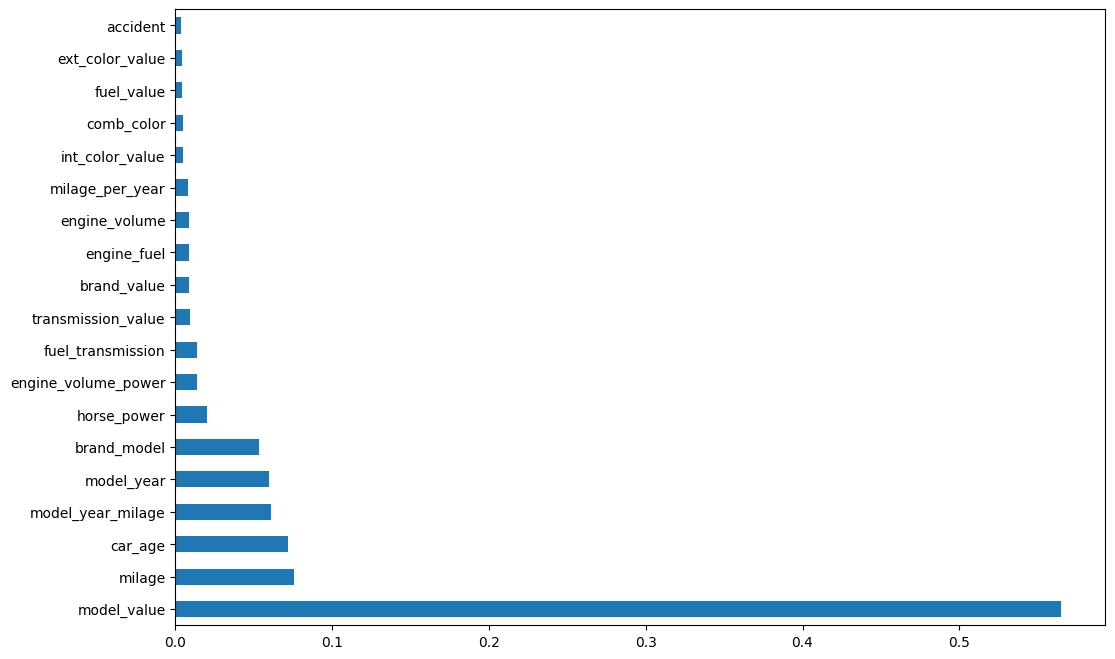

In [14]:
selection = TransformedTargetRegressor(regressor=ExtraTreesRegressor(n_jobs=-1))
selection.fit(X_train,y_train)
plt.figure(figsize = (12,8))
feat_importances = pd.Series(selection.regressor_.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

In [15]:
X_train_o, X_test_o = X_train.copy(), X_test.copy()

In [16]:
def final_df(df):
  # df = df.drop(['model_value', 'milage','model_year', ''], axis=1)
  # retrun df
  features_1 = ['accident', 'car_age', 'comb_color', 'engine_fuel',  'brand_model', 'horse_power', 'milage', 'transmission_value']
  features_2 = ['brand_value', 'fuel_value', 'transmission_value', 'car_age', 'milage', 'horse_power', 'engine_volume']
  # return df[features_1]
  return df[features_2]
  # return df[features_1+features_2]

In [17]:
X_train = final_df(X_train_o)
X_test = final_df(X_test_o)

In [18]:
lm = LinearRegression()
lm.fit(X_train, y_train)
print(lm.score(X_train, y_train))
print(lm.score(X_test,y_test))

Input=[('scale',StandardScaler()), ('polynomial', PolynomialFeatures(degree=2, include_bias=True)), ('model',LinearRegression())]
pipe=Pipeline(Input)
pipe.fit(X_train, y_train)
print(pipe.score(X_train,y_train))
print(pipe.score(X_test,y_test))

0.7114093525594344
0.6911115523422973
0.7795134700847159
0.7461045088781045


## Fit & Prediction & Evaluation

### Linear Model Pipeline

In [19]:
# Create a pipeline with the preprocessor and a classifier
model_linear = Pipeline(steps=[
    ('scale',StandardScaler()), 
    ('polynomial', PolynomialFeatures(degree=2, include_bias=True)),
    ('model', TransformedTargetRegressor(regressor=LinearRegression(n_jobs=-1)))
])

In [20]:
model_linear.fit(X_train, y_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('polynomial', PolynomialFeatures()),
                ('model',
                 TransformedTargetRegressor(regressor=LinearRegression(n_jobs=-1)))])

In [21]:
y_pred = model_linear.predict(X_test)

In [22]:
rmse = root_mean_squared_error(y_test, y_pred)
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 8537.923590553979


In [23]:
r2score = r2_score(y_test, y_pred)
print(f'R2 score : {r2score}')

R2 score : 0.7461045088781045


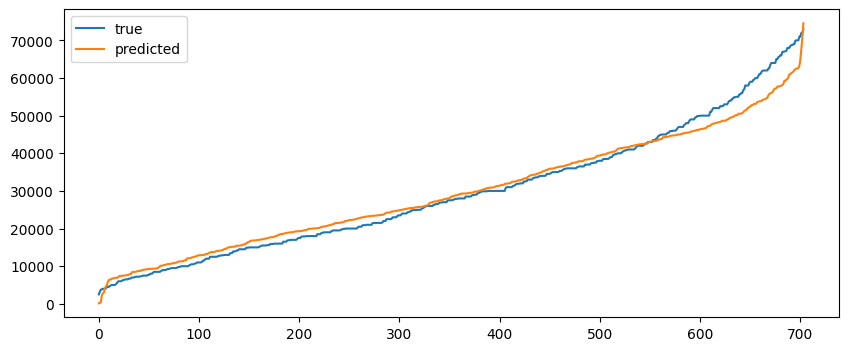

In [24]:
plt.figure(figsize=(10,4))
plt.plot(np.sort(y_test), label='true')
plt.plot(np.sort(y_pred), label='predicted')
plt.legend();

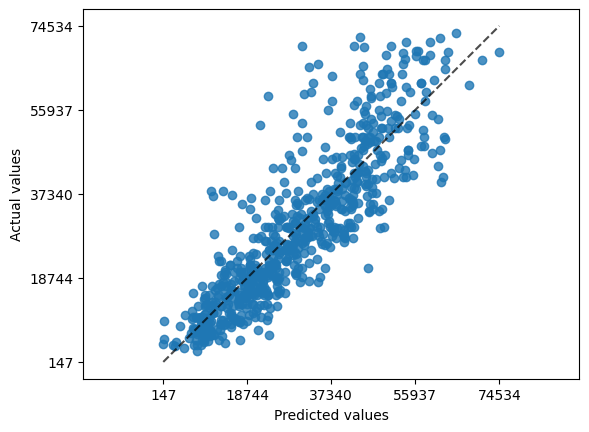

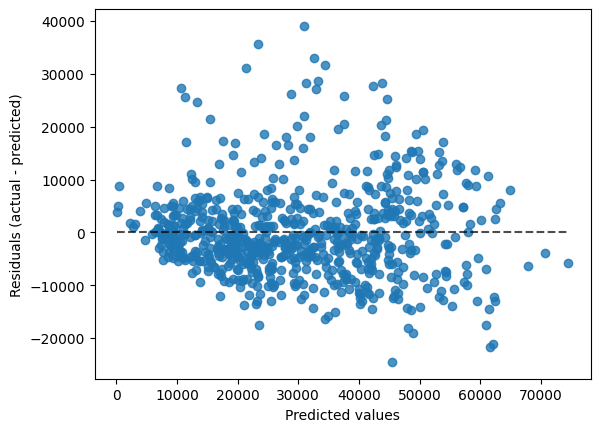

In [25]:
# display = PredictionErrorDisplay(y_true=y_test, y_pred=y_pred)
# display.plot();
display = PredictionErrorDisplay.from_predictions(y_test, y_pred, kind='actual_vs_predicted')
display.plot();

In [62]:
def adjusted_r2score(y_test, y_pred):
  r2 = r2_score(y_test, y_pred)
  n = len(y_test)  # Number of observations
  p = X_test.shape[1]  # Number of predictors
  adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
  return adjusted_r2

In [130]:
# Create a pipeline with the preprocessor and a classifier
rf_search = Pipeline(steps=[
    ('scale',StandardScaler()), 
    ('model', RandomForestRegressor())
])

# Define hyperparameter grid for RandomizedSearchCV
param_grid = {
    'model__n_estimators': [50, 100, 200, 400],
    'model__max_depth': [None, 10, 20, 40],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4, 8],
    'model__max_features': [1,'sqrt', 'log2'],
    'model__bootstrap': [True, False]
}


# Use RandomizedSearchCV to find the best hyperparameters
rf_search = GridSearchCV(estimator=rf_search, param_grid=param_grid, cv=3, n_jobs=-1, verbose=0, scoring='r2')

In [131]:
rf_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('model', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'model__bootstrap': [True, False],
                         'model__max_depth': [None, 10, 20, 40],
                         'model__max_features': [1, 'sqrt', 'log2'],
                         'model__min_samples_leaf': [1, 2, 4, 8],
                         'model__min_samples_split': [2, 5, 10],
                         'model__n_estimators': [50, 100, 200, 400]},
             scoring='r2')

In [132]:
y_pred = rf_search.predict(X_test)

In [133]:
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f'MAE: {mae}, RMSE: {rmse}, MSE: {mse}')

MAE: 5067.16995797822, RMSE: 7024.436357385053, MSE: 49342706.13895299


In [134]:
rf_search.score(X_train, y_train)

0.9856612606983708

In [135]:
rf_search.score(X_test, y_test)

0.8281405470939065

In [136]:
r2score = r2_score(y_test, y_pred)
print(f'R2 score : {r2score}')

R2 score : 0.8281405470939065


In [137]:
adjusted_r2score(y_test, y_pred)

0.8264120755847935

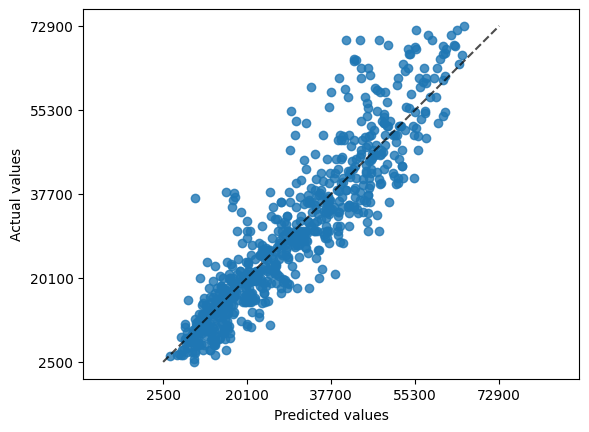

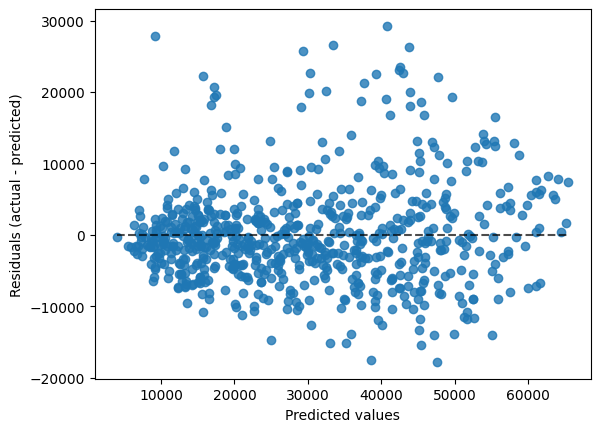

In [138]:
display = PredictionErrorDisplay.from_predictions(y_test, y_pred, kind='actual_vs_predicted')
display.plot();

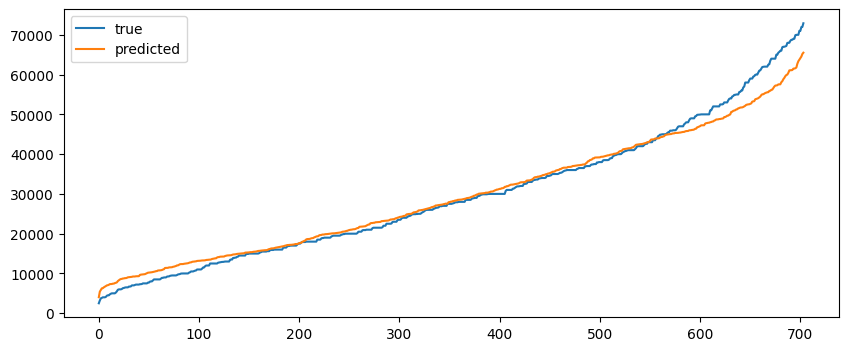

In [139]:
plt.figure(figsize=(10,4))
plt.plot(np.sort(y_test), label='true')
plt.plot(np.sort(y_pred), label='predicted')
plt.legend();

### XGBoost Regressor

In [100]:
# Create a pipeline with the preprocessor and a classifier
xgb_search = Pipeline(steps=[
    ('scale',StandardScaler()), 
    ('model', XGBRegressor(n_estimators=200, max_depth=10, max_leaves=20, learning_rate=0.1, n_jobs=-1))
])

# Define hyperparameter grid for RandomizedSearchCV
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [None, 6, 10, 20],
    'model__max_leaves': [5,10,20,40],
    'model__learning_rate': [0.1, 0.01, 0.001]
}

# Use RandomizedSearchCV to find the best hyperparameters
xgb_search = GridSearchCV(estimator=xgb_search, param_grid=param_grid, cv=5, n_jobs=-1, verbose=0, scoring='r2')

In [101]:
xgb_search.fit(X_train, y_train)

C:\Program Files\Python312\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('model',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     device=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=None,
                                                     feature_types=None,
                                                     gamma=None,
                                                     grow_policy=None,
                                                     importance_type=No...
                                                     max_depth=10,
                                                     max_leaves=20,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=200,
                                                     n_jobs=-1,
                                                     num_parallel_tree=None,
                                                     random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.1, 0.01, 0.001],
                         'model__max_depth': [None, 6, 10, 20],
                         'model__max_leaves': [5, 10, 20, 40],
                         'model__n_estimators': [50, 100, 200]},
             scoring='r2')

In [102]:
y_pred = xgb_search.predict(X_test)

In [103]:
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f'MAE: {mae}, RMSE: {rmse}, MSE: {mse}')

MAE: 4793.270999561657, RMSE: 6673.377275119548, MSE: 44533964.25608201


In [104]:
xgb_search.score(X_train, y_train)

0.9588833265811707

In [105]:
xgb_search.score(X_test, y_test)

0.8448892788482926

In [106]:
r2score = r2_score(y_test, y_pred)
print(f'R2 score : {r2score}')

R2 score : 0.8448892788482926


In [107]:
adjusted_r2score(y_test, y_pred)

0.843329257227514

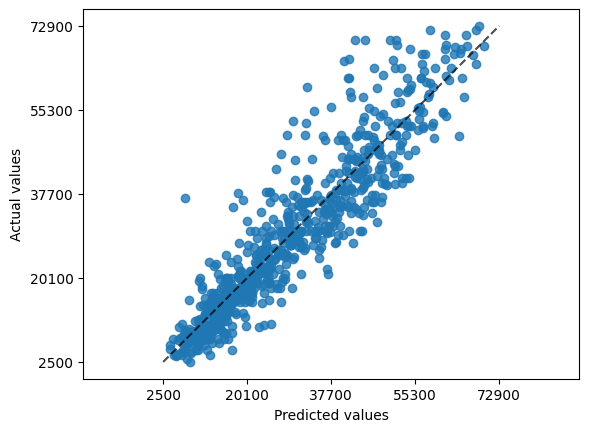

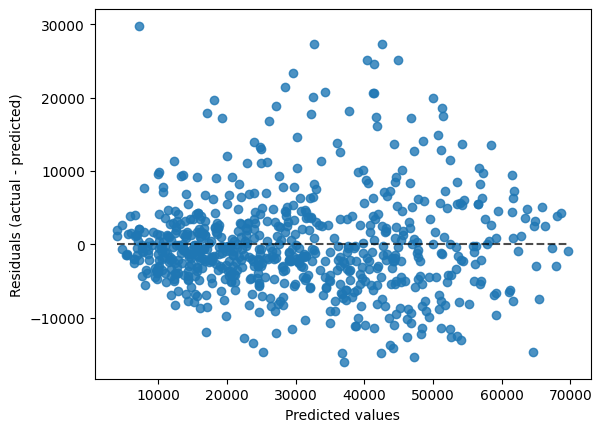

In [108]:
display = PredictionErrorDisplay.from_predictions(y_test, y_pred, kind='actual_vs_predicted')
display.plot();

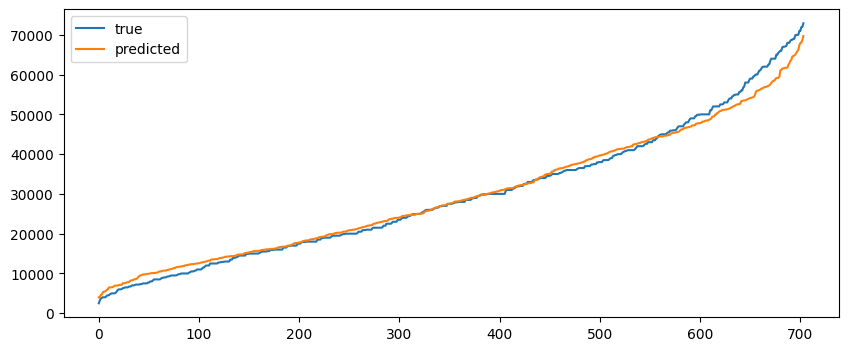

In [109]:
plt.figure(figsize=(10,4))
plt.plot(np.sort(y_test), label='true')
plt.plot(np.sort(y_pred), label='predicted')
plt.legend();

In [37]:
import gc
gc.collect()

11981

In [ ]:
del df
gc.collect()